# TimeGAN - Generating synthetic time series  

### Introduction 

The purpose of this project is to explore the potential of a generative adversarial network (GAN) to generate synthetic data. In many cases, the amount of data available to researchers is small, and collecting additional data is far too expensive. GANs have emerged in recent years as a potential means to overcome this issue. They work by utilising two neural networks (a generator network and a discriminative network) to contest against eachother in a zero-sum game. 

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking). In brief, the dataset consists of Accelerometer and transdermal alcohol content data from a college bar crawl and the data was originally used to predict heavy drinking episodes via mobile data.


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from ydata_synthetic.synthesizers.timeseries import TimeGAN

# mount the local files 
from google.colab import drive
os.chdir('/content/drive/MyDrive/Study/Bar-Crawl-Gan')


# check if gpu is being used 
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


#### Requirements 

In [2]:
pip list

Package                       Version       
----------------------------- --------------
absl-py                       0.12.0        
alabaster                     0.7.12        
albumentations                0.1.12        
altair                        4.1.0         
appdirs                       1.4.4         
argon2-cffi                   20.1.0        
arviz                         0.11.2        
astor                         0.8.1         
astropy                       4.2.1         
astunparse                    1.6.3         
async-generator               1.10          
atari-py                      0.2.6         
atomicwrites                  1.4.0         
attrs                         21.2.0        
audioread                     2.1.9         
autograd                      1.3           
Babel                         2.9.1         
backcall                      0.2.0         
beautifulsoup4                4.6.3         
bleach                        3.3.0         
blis      

In [3]:
# read files 
tac_files = os.listdir('data/clean_tac')
acc_data = pd.read_csv('data/all_accelerometer_data_pids_13.csv')
phone_types = pd.read_csv('data/phone_types.csv')

### Prepare data 

* Include only iphone data
* Downsample the accelerometer data 
* Join the TAC and ACC files

In [4]:
#drop non iphone
to_include=phone_types.loc[phone_types['phonetype'] == 'iPhone'].pid.unique()
acc_data = acc_data.loc[acc_data['pid'].isin(to_include)].copy()

# get the tac data
tac_list = [] # for data 
for f in tac_files:
    path= 'data/clean_tac/' + f # path for each file 
    file = pd.read_csv(path) # read in the data
    file['pid'] = f.replace('_clean_TAC.csv', '') # add an identifier 
    tac_list.append(file) # append to list

TAC_files = pd.concat(tac_list) # concatenate 

# remove 0 time stamp
acc_data = acc_data.loc[acc_data.time != 0].copy()

In [5]:
# get the unique ids 
acc_data.pid.unique()

array(['SA0297', 'PC6771', 'BK7610', 'DC6359', 'MC7070', 'MJ8002',
       'BU4707', 'JR8022', 'HV0618', 'SF3079', 'DK3500'], dtype=object)

In [6]:
# get the unique ids 
TAC_files.pid.unique()

array(['JR8022', 'SA0297', 'DC6359', 'DK3500', 'CC6740', 'BK7610',
       'SF3079', 'BU4707', 'MJ8002', 'JB3156', 'MC7070', 'HV0618',
       'PC6771'], dtype=object)

In [7]:
print(acc_data.head())

            time     pid       x       y       z
2  1493733882409  SA0297  0.0758  0.0273 -0.0102
3  1493733882455  SA0297 -0.0359  0.0794  0.0037
4  1493733882500  SA0297 -0.2427 -0.0861 -0.0163
5  1493733883945  SA0297 -0.2888  0.0514 -0.0145
6  1493733883953  SA0297 -0.0413 -0.0184 -0.0105


In [8]:

def process_data(subj, verbose = True, plot = True, interpolate = True):
    
    '''
    This function will create datasets for each of the subjects
    
    
    subj : a unique identifier for each subject. This is used to join the TAC 
    verbose : would you like some information printed about the length of the time series? 
    plot : Would you like to plot the tac time series? 
    interpolate : Would you like to use linear interpolation between the alcohol measures? 
    '''
    acc_temp = acc_data.loc[acc_data['pid'] == subj].copy()
    tac_temp = TAC_files.loc[TAC_files['pid'] == subj].copy() 

    # convert to time  
    acc_temp['timestamp_s'] = pd.to_datetime(acc_temp.time/1000, unit='s') 
    tac_temp['timestamp_s'] = pd.to_datetime(tac_temp.timestamp, unit='s')

    # set date indexes 
    acc_temp.set_index('timestamp_s', inplace = True)
    acc_temp = acc_temp.resample("1s").mean()
    tac_temp.set_index('timestamp_s', inplace = True)

    # how long were the measures? 
    if verbose:
        print('For subject', subj, 'the acceleration data spans', acc_temp.index.max() -  acc_temp.index.min())
        print('For subject', subj, 'the TAC data spans', tac_temp.index.max() -  tac_temp.index.min())


    subject_data = pd.merge(acc_temp, tac_temp, left_index = True, right_index = True, how = 'outer') 

    # fill gaps
    if interpolate:
        subject_data['TAC_Reading'] = subject_data['TAC_Reading'].interpolate(method = 'linear') # interpolate the alcohol measures 


    
        
    # select the columns we need
    subject_data = subject_data[['x', 'y', 'z', 'TAC_Reading']].copy()
    subject_data = subject_data.loc[subject_data['x'].notnull()].copy()
    
    # add identifier 
    subject_data['pid'] = subj
    
    subject_data = subject_data.iloc[::10] # get every 10th  
    subject_data = subject_data.iloc[:500] # get 500
    # plot the subject 
    if plot:
        subject_data.plot(subplots=True, figsize=(15,6))
        plt.show(); 
    
    #return final
    return subject_data

For subject SA0297 the acceleration data spans 1 days 01:14:13
For subject SA0297 the TAC data spans 1 days 00:49:31


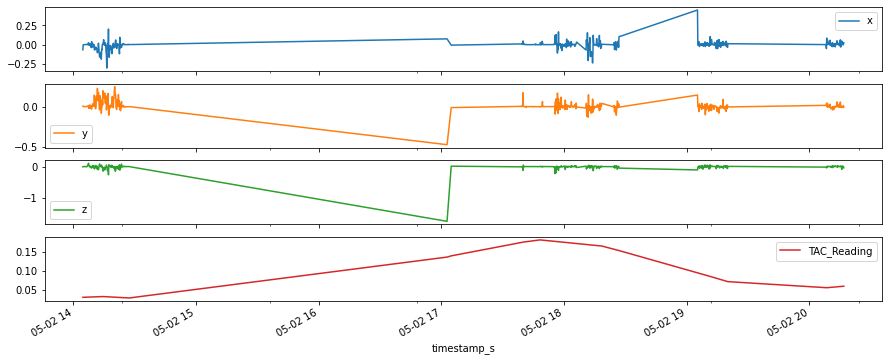

For subject PC6771 the acceleration data spans 0 days 23:56:40
For subject PC6771 the TAC data spans 0 days 23:55:21


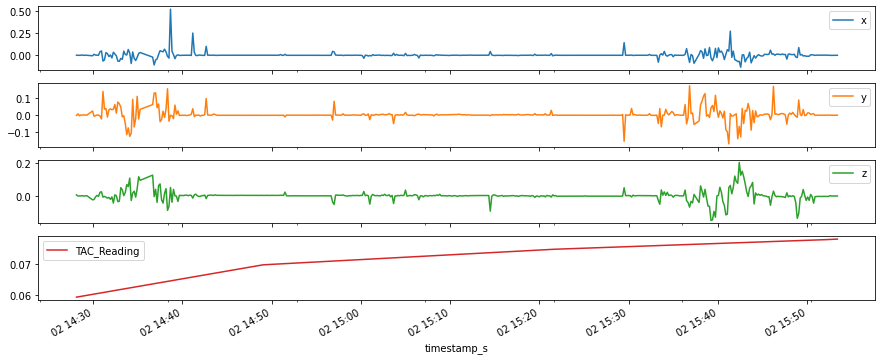

For subject BK7610 the acceleration data spans 0 days 08:51:40
For subject BK7610 the TAC data spans 1 days 00:46:25


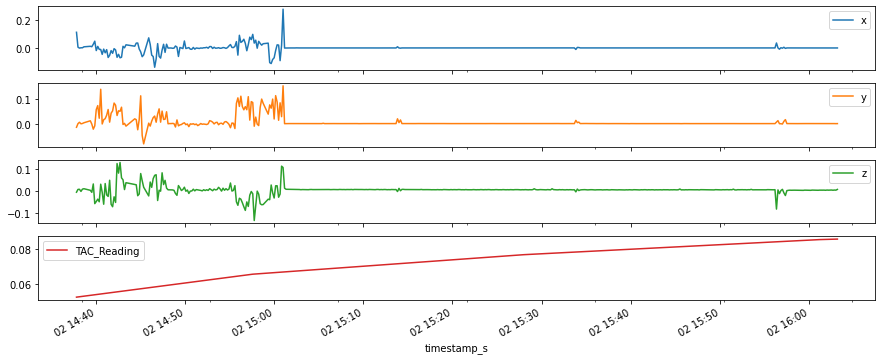

For subject DC6359 the acceleration data spans 0 days 09:02:57
For subject DC6359 the TAC data spans 0 days 23:20:24


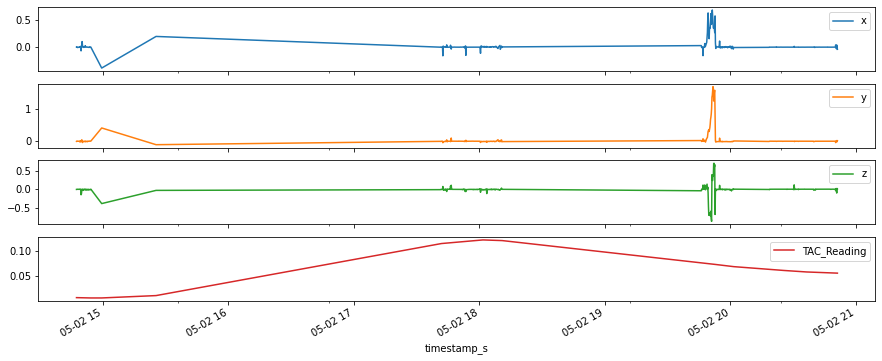

For subject MC7070 the acceleration data spans 0 days 12:28:08
For subject MC7070 the TAC data spans 0 days 23:47:42


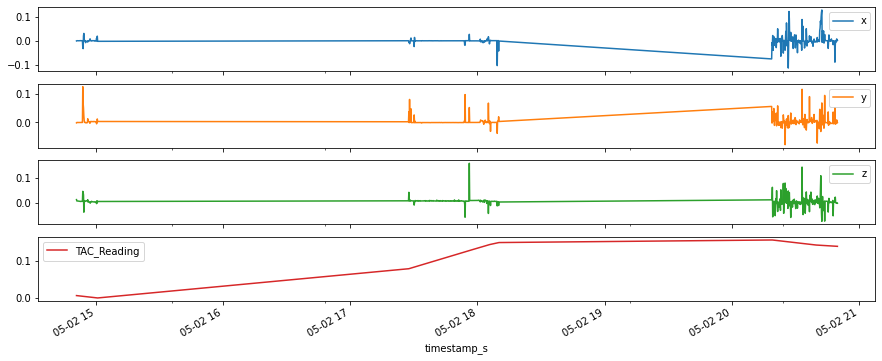

For subject MJ8002 the acceleration data spans 0 days 13:20:02
For subject MJ8002 the TAC data spans 1 days 01:19:46


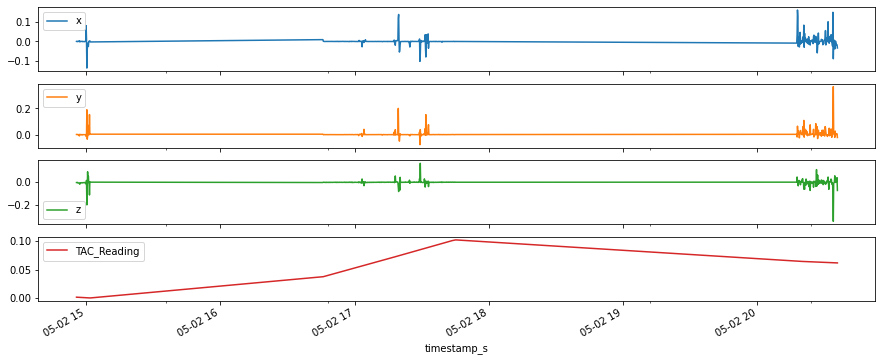

For subject BU4707 the acceleration data spans 0 days 05:40:18
For subject BU4707 the TAC data spans 1 days 00:46:25


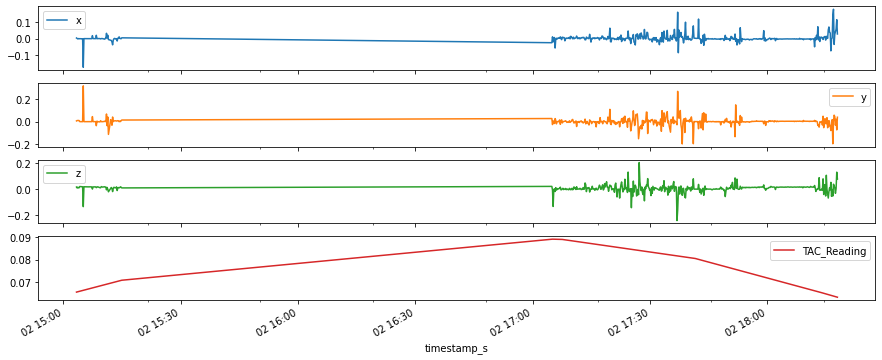

For subject JR8022 the acceleration data spans 0 days 09:28:19
For subject JR8022 the TAC data spans 0 days 23:01:12


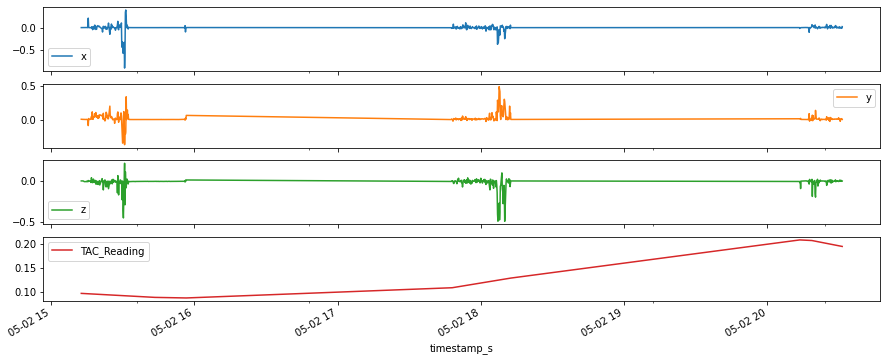

For subject HV0618 the acceleration data spans 0 days 23:58:46
For subject HV0618 the TAC data spans 0 days 23:18:40


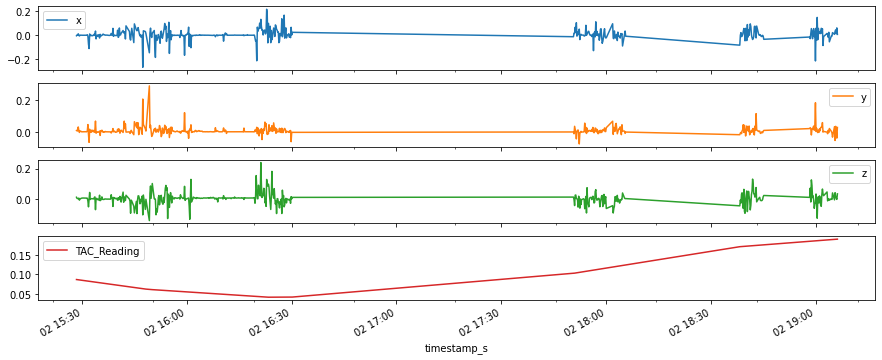

For subject SF3079 the acceleration data spans 0 days 14:20:29
For subject SF3079 the TAC data spans 0 days 23:00:20


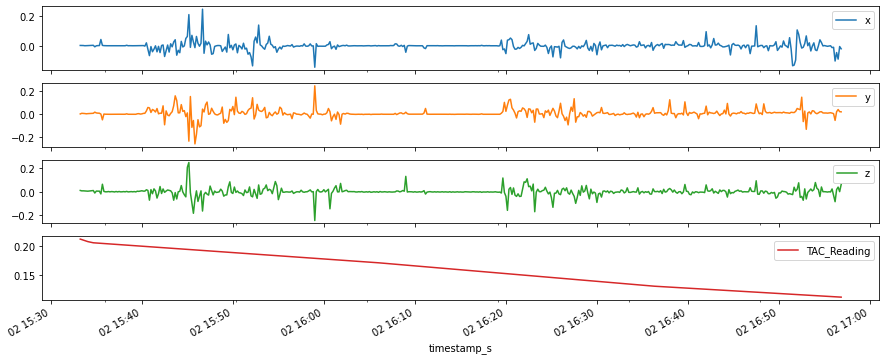

For subject DK3500 the acceleration data spans 0 days 18:06:16
For subject DK3500 the TAC data spans 0 days 21:12:21


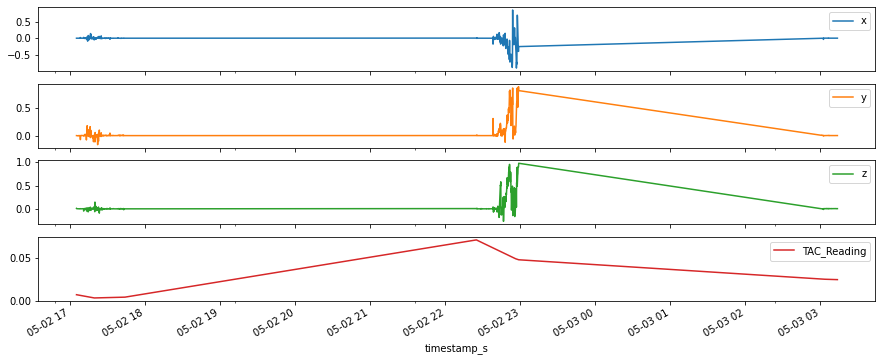

In [9]:
# Get the results 
results_list= []
for subj in acc_data.pid.unique():
    results_list.append(process_data(subj))

In [10]:
data =pd.concat(results_list)
print(data.head())

                            x         y         z  TAC_Reading     pid
timestamp_s                                                           
2017-05-02 14:04:42 -0.067600  0.006867 -0.007600     0.030570  SA0297
2017-05-02 14:04:52 -0.001473  0.000177 -0.002505     0.030607  SA0297
2017-05-02 14:05:02 -0.000800  0.000277 -0.003118     0.030644  SA0297
2017-05-02 14:05:12  0.000536 -0.000064 -0.003059     0.030682  SA0297
2017-05-02 14:05:22 -0.000050 -0.000109 -0.001514     0.030719  SA0297


# Implement the GAN 

This work tests [TimeGAN](https://papers.nips.cc/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf). The paragraph below summarises the work by Yoon, Jarrett and  van der Schaar. 

TimeGAN is a method to synthesise realistic time-series data in various domains. In TimeGAN, a stepwise supervised loss using the original data as supervision is used, this aims to learn the stepwise conditional distributions in the data and allows learning from the transition dynamics from real sequences.
TimeGAN also introduces an embedding network which helps to decrease  the dimensionality of the adversarial learning space, this is rationalised by the assumption that complex systems are generally driven by fewer
and lower-dimensional factors of variation. The embedding and generator networks are trained concurrently to minimise the loss on the supervised network, thus, the latent space promotes parameter efficiency and is specifically conditioned to facilitate the generator in learning
temporal relationships. Another excellent example of the performance of TimeGAN for the generation of synthetic stock data is available [here](https://colab.research.google.com/github/ydataai/ydata-synthetic/blob/master/examples/timeseries/TimeGAN_Synthetic_stock_data.ipynb) .


In [11]:
# write a copy of the data 
data.to_csv('data/unscaled_processed_data.csv')

In [12]:
# scale the data 
scaler = MinMaxScaler()
scaler.fit(data.iloc[:, 0:4])

# get train and test
ppts = data.pid.unique()
train_ppts = ppts[:7]
test_ppts = ppts[7:]

# get the data ready for gan
acc_data = []
for p in train_ppts:
    tmp = data[data['pid'] == p][['x','y','z','TAC_Reading']].copy()
    acc_data.append(scaler.transform(tmp)) # get the scaled data 


# dimensions of input data
print(len(acc_data),acc_data[0].shape)

7 (500, 4)


In [13]:
# set the seed to allow reproduction
tf.random.set_seed(42)
# time gan variables
seq_len=500 
n_seq = 4 
hidden_dim=500
gamma=1
noise_dim = 10
dim = 16
batch_size = 7
log_step = 10
learning_rate = 0.001
gan_params = [batch_size, learning_rate, noise_dim, 70, 2, (0, 1), dim]


gan = TimeGAN(model_parameters=gan_params, 
                hidden_dim=hidden_dim, 
                seq_len=seq_len, 
                n_seq=n_seq, 
                gamma=gamma)
gan.train(acc_data, train_steps=5000) # train for 5000 steps 

Joint networks training: 100%|██████████| 5000/5000 [4:04:08<00:00,  2.93s/it]


In [14]:
# get the outputs 
synth_data = gan.sample(len(acc_data))

Synthetic data generation: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


In [15]:
# write out the synthesised f
seq_generated = len(synth_data)
for s in np.arange(len(synth_data)):
    dat_synth = pd.DataFrame(scaler.inverse_transform(synth_data[s]), columns = ['x','y','z','TAC_Reading'])
    dat_synth['time'] =  np.arange(0,5000, 10) # gen a synthetic time series 
    path = 'data/synth_data/data_' + str(s) + '.csv'
    dat_synth.to_csv(path)